# 2nd Assignment
## Exercise 3
2023/5/27

In [ ]:
import random
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from abc import ABC, abstractmethod
from typing import Optional
import sys

## **Methods and Classes**

In [ ]:
def calculate(population, current):
    time = 0.0
    dt = 0.01
    population_spikes = []
    inner_connection_weight = 500
    inner_current = np.zeros_like(current)
    for i in range(100):
        inner_current , spikes = population.forward(current[i] + inner_current, time, dt)
        inner_current *= inner_connection_weight
        population_spikes.append(spikes)
        time += dt
    spikes = np.array(population_spikes).T.tolist()
    rates = []
    for i in range(len(spikes)):
        rates.append(len(spikes[0]) - spikes[i].count(0))
    return rates, torch.tensor(population_spikes).T.tolist()

In [ ]:
class AbstractEncoder(ABC):


    def __init__(
        self,
        time: int,
        dt: Optional[float] = 1.0,
        device: Optional[str] = "cpu",
        **kwargs
    ) -> None:
        self.time = time
        self.dt = dt
        self.device = device

    @abstractmethod
    def __call__(self, data: torch.Tensor) -> None:

        pass



class PoissonEncoder(AbstractEncoder):


    def __init__(
        self,
        time: int,
        dt: Optional[float] = 1.0,
        device: Optional[str] = "cpu",
        **kwargs
    ) -> None:
        super().__init__(
            time=time,
            dt=dt,
            device=device
        )

    def __call__(self, data: torch.Tensor) -> torch.Tensor:

        shape, size = data.shape, data.numel()
        data = data.flatten().to(self.device)
        time = int(self.time / self.dt)

        rate = torch.zeros(size, device=self.device)
        rate[data != 0] = 1 / data[data != 0] * (1000 / self.dt)

        dist = torch.distributions.Poisson(rate=rate, validate_args=False)
        intervals = dist.sample(sample_shape=torch.Size([time + 1]))
        intervals[:, data != 0] += (intervals[:, data != 0] == 0).float()

        times = torch.cumsum(intervals, dim=0).long()
        times[times >= time + 1] = 0

        spikes = torch.zeros(time + 1, size, device=self.device).byte()
        spikes[times, torch.arange(size)] = 1
        spikes = spikes[1:]

        return spikes.view(time, *shape)


class RankOrderEncoder(AbstractEncoder):


    def __init__(
        self,
        time: int,
        dt: Optional[float] = 1.0,
        device: Optional[str] = "cpu",
        **kwargs
    ) -> None:
        super().__init__(
            time=time,
            dt=dt,
            device=device,
            **kwargs
        )

    def __call__(self, data: torch.Tensor) -> None:
        shape, size = data.shape, data.numel()
        data = data.flatten().to(self.device)
        time = int(self.time / self.dt)

        times = torch.zeros(size)
        times[data != 0] = 1 / data[data != 0]
        times *= time / times.max()
        times = torch.ceil(times).long()

        spikes = torch.zeros(time, size, device=self.device).byte()
        for i in range(size):
            if 0 < times[i] <= time:
                spikes[times[i] - 1, i] = 1

        return spikes.reshape(time, *shape)


class TimeToFirstSpikeEncoder(AbstractEncoder):

    def __init__(
        self,
        time: int,
        dt: Optional[float] = 1.0,
        device: Optional[str] = "cpu",
        **kwargs
    ) -> None:
        super().__init__(
            time=time,
            dt=dt,
            device=device,
            **kwargs
        )

    def __call__(self, data: torch.Tensor) -> None:
        shape, size = data.shape, data.numel()
        data = data.flatten().to(self.device)
        time = int(self.time / self.dt)

        times = torch.zeros(size)
        times[data != 0] = data[data != 0] / data.max()
        times = torch.floor(times).long()

        spikes = torch.zeros(time, size, device=self.device).byte()
        for i in range(size):
            if 0 < times[i] <= time:
                spikes[times[i] - 1, i] = 1

        return spikes.reshape(time, *shape)

In [ ]:
class LIF:

    def __init__(self,R,tau,u_rest,threshold,u_spike,u_reset):
        self.history=[]
        self.spikes=[]
        self.current=[]
        self.R=R
        self.tau=tau
        self.u=u_rest
        self.u_rest=u_rest
        self.threshold=threshold
        self.u_spike=u_spike
        self.u_reset=u_reset


    def forward(self,input_current,time,dt):
        du=dt*(-1*(self.u-self.u_rest)+1e-3*self.R*input_current)/self.tau
        self.u+=du
        time+=dt
        self.history.append((self.u,time))
        self.current.append((input_current,time))
        if self.u>self.threshold:
                self.spikes.append(time)
                self.reset()
                return 1
        return 0

    def reset(self):
        self.u=self.u_reset

    def to_rest(self):
        self.u=self.u_rest

    def clear_history(self):
        self.history=[]
        self.spikes=[]
        self.current=[]
        self.u=self.u_rest

In [ ]:
class NeuronPopulation:

    def __init__(self,population_type,connection_details:dict,neuron_list:list):
        self.activity=[]
        self.neuron_list=neuron_list
        self.connections=np.zeros((len(neuron_list),len(neuron_list)))
        self.connection_details=connection_details
        set_connection=eval('self.'+self.connection_details['type'])
        self.population_type=population_type
        set_connection()

    def fully_connection(self):
        self.connections = np.ones_like(self.connections)*(self.connection_details['j']/len(self.neuron_list))
        self.inhibitory_coeff_mannager()

    def fully_connection_with_normal_distribution(self):
        self.connections = (np.ones_like(self.connections).reshape(-1) *
                            np.random.normal(loc=self.connection_details['j']/len(self.neuron_list),
                                              scale=1.0,
                                              size=len(self.neuron_list)**2
                                            )
                           )
        self.connections = self.connections.reshape(len(self.neuron_list), len(self.neuron_list))
        self.inhibitory_coeff_mannager()

    def random_connection_with_fixed_coupling_probablity(self):
        self.connections = np.ones_like(self.connections)*(self.connection_details['j']/len(self.neuron_list))
        self.connections = (self.connections.reshape(-1)*
                            np.random.choice([0, 1], p=[self.connection_details['p'],1-self.connection_details['p']], size=len(self.neuron_list)**2)
                           )
        self.connections = self.connections.reshape(len(self.neuron_list), len(self.neuron_list))
        self.inhibitory_coeff_mannager()

    def random_connection_with_fixed_number_of_presynaptic_partners(self):
        self.connections = np.ones_like(self.connections)*(self.connection_details['j']/len(self.neuron_list))
        zero_w = len(self.neuron_list) - int(self.connection_details['p'] * len(self.neuron_list))
        self.connections = self.connections.T
        for i in range(len(self.neuron_list)):
            zero_ind = np.random.choice(range(len(self.neuron_list)), size=zero_w)
            self.connections[i][zero_ind] = 0
        self.connections = self.connections.T


        self.inhibitory_coeff_mannager()

    def forward(self,input_current,time,dt):
        result = []
        for i,neuron in enumerate(self.neuron_list):
            result.append(neuron.forward(input_current[i],time,dt))
        self.activity.append(sum(result)/(len(neuron_list)*dt))
        activity=np.array([result]) @ self.connections.T
        return activity[0] , result

    def reset(self,reset_connection=False):
        self.activity=[]
        if reset_connection:
            set_connection=eval('self.'+self.connection_details['type'])
            set_connection()
        for neuron in self.neuron_list:
            neuron.clear_history()

    def inhibitory_coeff_mannager(self):
        if self.population_type=='inhibitory':
            self.connections=-1*self.connections


    def raster_plot_data(self,index):
        x=[]
        y=[]
        for i,neuron in enumerate(self.neuron_list):
            id=f'{index}#{i}'
            for l in neuron.spikes:
                x.append(l)
                y.append(id)
        return x,y

## **Define population**

In [ ]:
population_size = 10
neuron_list = []
for i in range(population_size):
    neuron_list.append(LIF(10+np.random.rand()*2,8+np.random.rand()*2,random.randint(-85, 75),random.randint(-60, -50), random.uniform(4.2, 5), random.randint(-70, -65)))

In [ ]:
connection_details={
    'type':'fully_connection',
    'j':100
}
population=NeuronPopulation('exitatory',connection_details,neuron_list)

In [ ]:
rates1, spikes1 = calculate(population, [250000] * 100)
print(rates1)
rates2, spikes2 = calculate(population, [200000] * 100)
print(rates2)
rates3, spikes3 = calculate(population, [150000] * 100)
print(rates3)
rates4, spikes4 = calculate(population, [100000] * 100)
print(rates4)
rates5, spikes5 = calculate(population, [50000] * 100)
print(rates5)

[33, 20, 25, 34, 25, 20, 25, 33, 50, 17]
[34, 14, 20, 25, 20, 17, 22, 25, 33, 12]
[25, 12, 14, 20, 16, 13, 17, 20, 31, 10]
[16, 7, 10, 14, 11, 9, 13, 15, 20, 7]
[10, 4, 5, 8, 7, 4, 6, 8, 11, 4]


## **Poisson Encoder**

In [ ]:
pen = PoissonEncoder(time=200)

In [ ]:
code11 = pen(torch.tensor(rates1))
code12 = pen(torch.tensor(rates2))
code13 = pen(torch.tensor(rates3))
code14 = pen(torch.tensor(rates4))
code15 = pen(torch.tensor(rates5))

Encoded data for current 1


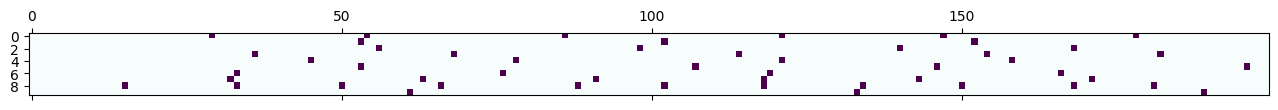

In [ ]:
print("Encoded data for current 1")
plt.matshow(code11.T.tolist(), cmap="BuPu");

Encoded data for current 2


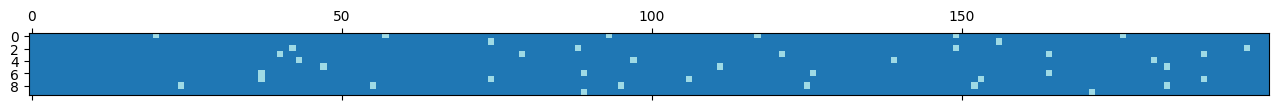

In [ ]:
print("Encoded data for current 2")
plt.matshow(code12.T.tolist(), cmap="tab20");

Encoded data for current 3


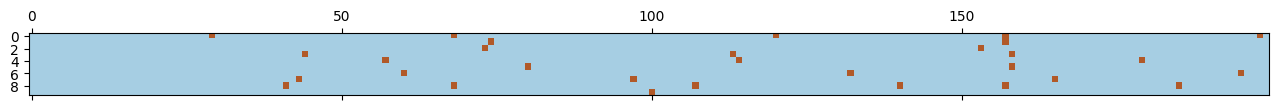

In [ ]:
print("Encoded data for current 3")
plt.matshow(code13.T.tolist(), cmap="Paired");

Encoded data for current 4


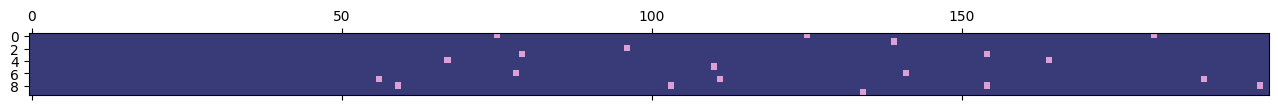

In [ ]:
print("Encoded data for current 4")
plt.matshow(code14.T.tolist(), cmap="tab20b");

Encoded data for current 5


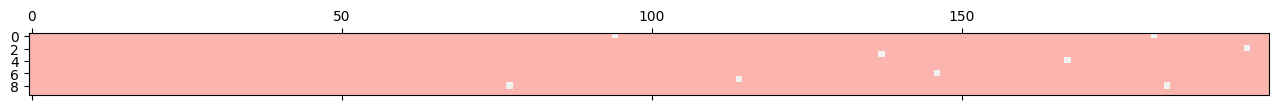

In [ ]:
print("Encoded data for current 5")
plt.matshow(code15.T.tolist(), cmap="Pastel1");

## **Rank Order Encoder**

In [ ]:
ren = RankOrderEncoder(time=100)

In [ ]:
code21 = ren(torch.tensor(rates1))
code22 = ren(torch.tensor(rates2))
code23 = ren(torch.tensor(rates3))
code24 = ren(torch.tensor(rates4))
code25 = ren(torch.tensor(rates5))

Encoded data for current 1


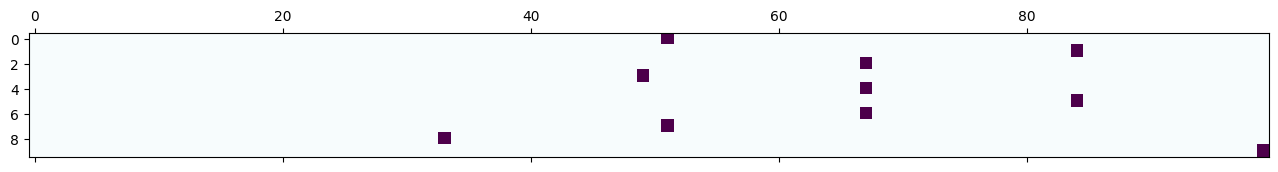

In [ ]:
print("Encoded data for current 1")
plt.matshow(code21.T.tolist(), cmap="BuPu");

Encoded data for current 2


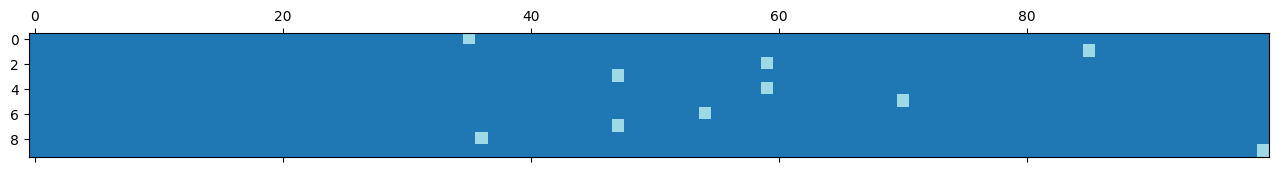

In [ ]:
print("Encoded data for current 2")
plt.matshow(code22.T.tolist(), cmap="tab20");

Encoded data for current 3


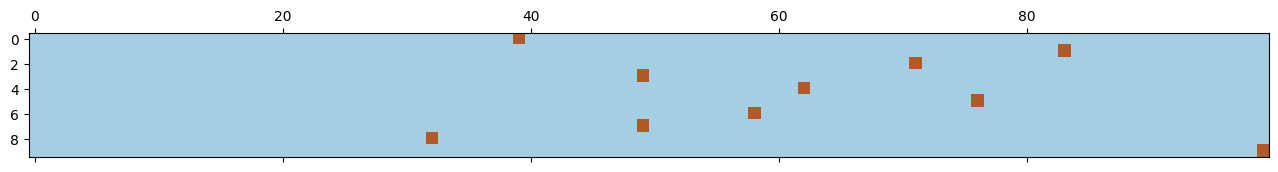

In [ ]:
print("Encoded data for current 3")
plt.matshow(code23.T.tolist(), cmap="Paired");

Encoded data for current 4


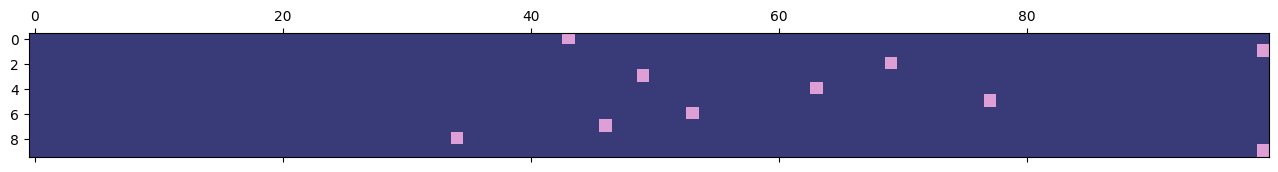

In [ ]:
print("Encoded data for current 4")
plt.matshow(code24.T.tolist(), cmap="tab20b");

Encoded data for current 5


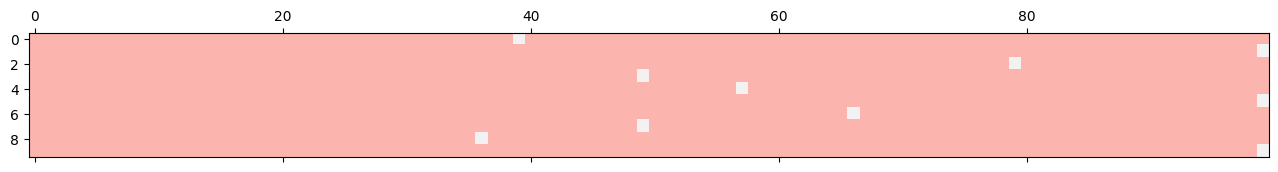

In [ ]:
print("Encoded data for current 5")
plt.matshow(code25.T.tolist(), cmap="Pastel1");

## **Time To First Spike Encoder**

In [ ]:
ten = TimeToFirstSpikeEncoder(time=100)

In [ ]:
ttfs1 = [spikes1[i].index(1) for i in range(len(spikes1))]
ttfs2 = [spikes2[i].index(1) for i in range(len(spikes1))]
ttfs3 = [spikes3[i].index(1) for i in range(len(spikes1))]
ttfs4 = [spikes4[i].index(1) for i in range(len(spikes1))]
ttfs5 = [spikes5[i].index(1) for i in range(len(spikes1))]

In [ ]:
code31 = ren(torch.tensor(ttfs1) + torch.ones_like(torch.tensor(ttfs1)))
code32 = ren(torch.tensor(ttfs2) + torch.ones_like(torch.tensor(ttfs2)))
code33 = ren(torch.tensor(ttfs3) + torch.ones_like(torch.tensor(ttfs3)))
code34 = ren(torch.tensor(ttfs4) + torch.ones_like(torch.tensor(ttfs4)))
code35 = ren(torch.tensor(ttfs5) + torch.ones_like(torch.tensor(ttfs5)))

Encoded data for current 1


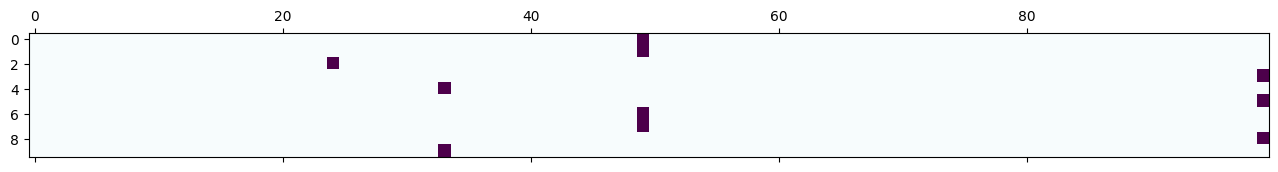

In [ ]:
print("Encoded data for current 1")
plt.matshow(code31.T.tolist(), cmap="BuPu");

Encoded data for current 2


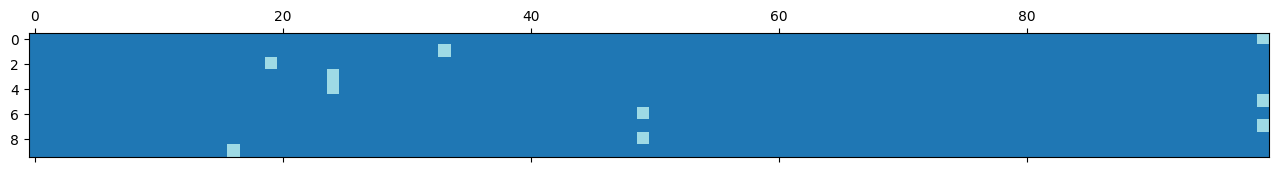

In [ ]:
print("Encoded data for current 2")
plt.matshow(code32.T.tolist(), cmap="tab20");

Encoded data for current 3


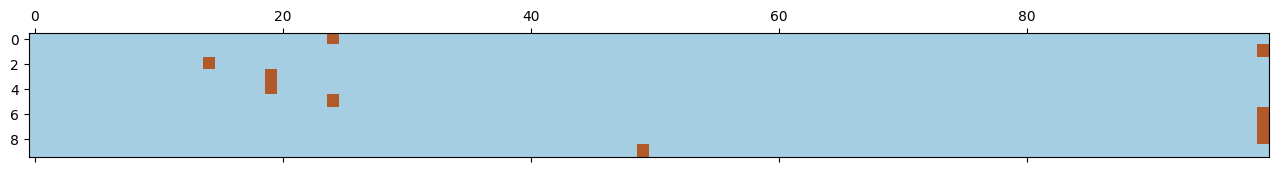

In [ ]:
print("Encoded data for current 3")
plt.matshow(code33.T.tolist(), cmap="Paired");

Encoded data for current 4


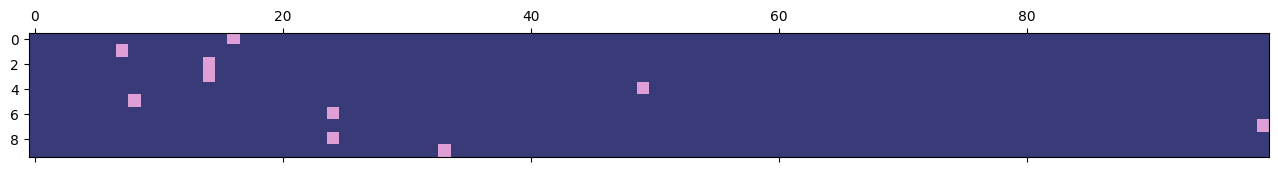

In [ ]:
print("Encoded data for current 4")
plt.matshow(code34.T.tolist(), cmap="tab20b");

Encoded data for current 5


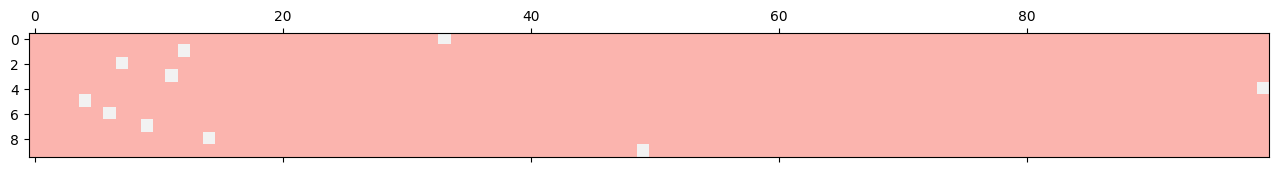

In [ ]:
print("Encoded data for current 5")
plt.matshow(code35.T.tolist(), cmap="Pastel1");